In [246]:
# Running RandomForest regressions to discover a lifters best lift
# across the 3 lifts.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits

In [247]:
# Sampling 20,000 data entries
n = 767672 
s = 20000
skip = sorted(random.sample(range(1,n+1),n-s))
data = pd.read_csv('zeroopenpowerlifting.csv', skiprows=skip)
data

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date
0,Ainslee Hooper,F,B,Raw,40.0,40-44,F-OR,55.40,56,0.0,...,32.5,1,38.56,38.56,34.12,313.97,NaN,NaN,GPC-AUS,2018-10-27
1,Daniel Theyers,M,SBD,Wraps,31.0,24-34,M-OR,81.50,82.5,140.0,...,420.0,8,283.44,283.44,273.71,397.42,NaN,NaN,GPC-AUS,2018-10-27
2,Melissa Clarke,F,SBD,Wraps,31.0,24-34,F-OR,106.40,90+,175.0,...,480.0,3,393.18,393.18,335.04,666.83,NaN,NaN,GPC-AUS,2015-05-19
3,Billy Chan,M,SBD,Wraps,29.0,24-34,M-OR,87.80,90,0.0,...,NaN,DQ,NaN,NaN,NaN,NaN,NaN,NaN,GPC-AUS,2015-05-19
4,Chris Fisher,M,SBD,Wraps,25.0,24-34,M-OR,109.70,110,230.0,...,705.0,14,415.24,415.24,397.81,600.41,NaN,Australia,GPC-AUS,2015-05-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Tezra Bailey,F,SBD,Wraps,47.5,45-49,wm1,66.18,67.5,0.0,...,310.0,1,320.95,347.26,283.21,523.11,Yes,USA,NASA,2019-11-09
19996,Win Smith,M,B,Raw,76.5,75-79,m4,78.24,82.5,0.0,...,70.0,1,48.48,90.94,46.75,296.50,Yes,USA,NASA,2020-01-25
19997,Terri VandeVegte,F,BD,Raw,59.0,55-59,wm2,122.47,90+,0.0,...,237.5,1,189.23,248.84,160.16,NaN,Yes,USA,NASA,2019-06-22
19998,Willie Agnew,M,SBD,Wraps,56.5,55-59,m2,89.81,90,0.0,...,615.0,1,393.04,489.72,376.72,581.81,Yes,USA,NASA,2019-10-05


In [248]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass', 'Division',
                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested', 'Country', 'Federation',
                          'Date', 'IPFPoints', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Glossbrenner',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                   0
Event                 0
Equipment             0
Age                   0
BodyweightKg          0
Best3SquatKg          0
Best3BenchKg          0
Best3DeadliftKg       0
Wilks              1157
dtype: int64

In [249]:
# General dropna just  to clear those without a WILKS
data = data.dropna()

In [250]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)

In [251]:
# Remove the last couple of columns
data = data.drop(columns = ['Event'])

In [252]:
data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
1,M,Wraps,31.0,81.50,160.0,80.0,180.0,283.44
2,F,Wraps,31.0,106.40,195.0,112.5,172.5,393.18
4,M,Wraps,25.0,109.70,265.0,160.0,280.0,415.24
5,M,Wraps,21.0,67.20,210.0,127.5,240.0,446.86
6,M,Wraps,33.0,82.50,190.0,110.0,245.0,365.10
...,...,...,...,...,...,...,...,...
19992,M,Raw,49.0,99.79,232.5,187.5,232.5,397.44
19993,F,Raw,37.0,66.59,97.5,67.5,137.5,311.78
19995,F,Wraps,47.5,66.18,105.0,67.5,137.5,320.95
19998,M,Wraps,56.5,89.81,220.0,187.5,207.5,393.04


In [253]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
1,1,1,31.0,81.50,160.0,80.0,180.0,283.44
2,0,1,31.0,106.40,195.0,112.5,172.5,393.18
4,1,1,25.0,109.70,265.0,160.0,280.0,415.24
5,1,1,21.0,67.20,210.0,127.5,240.0,446.86
6,1,1,33.0,82.50,190.0,110.0,245.0,365.10
...,...,...,...,...,...,...,...,...
19992,1,0,49.0,99.79,232.5,187.5,232.5,397.44
19993,0,0,37.0,66.59,97.5,67.5,137.5,311.78
19995,0,1,47.5,66.18,105.0,67.5,137.5,320.95
19998,1,1,56.5,89.81,220.0,187.5,207.5,393.04


In [254]:
# Normalise the data, scaling to values between 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

In [299]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_squat = data[[ 'Sex', 'Age', 'BodyweightKg', 'Equipment', 'Best3BenchKg', 'Best3DeadliftKg','Wilks']]

target_squat = data[['Best3SquatKg']]

test_bench = data[['Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_bench = data[['Best3BenchKg']]

test_dead = data[['Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_dead = data[['Best3DeadliftKg']]

In [300]:
# Preparing sets
S = test_squat
s = target_squat
B = test_bench
b = target_bench
D = test_dead
d = target_dead

In [301]:
# Split sets into training and test sets
from sklearn.model_selection import train_test_split
S_train, S_test, s_train, s_test = train_test_split(S, s, test_size=0.1, random_state=3)
B_train, B_test, b_train, b_test = train_test_split(B, b, test_size=0.1, random_state=3)
D_train, D_test, d_train, d_test = train_test_split(D, d, test_size=0.1, random_state=3)

In [302]:
# Prepare model, then fit the models and check scores!
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth = 30)

In [303]:
model.fit(S_train, s_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [304]:
S_pred = model.predict(S_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(S_pred , s_test))

R2-score: 0.97


In [295]:
model.fit(B_train, b_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [296]:
B_pred = model.predict(B_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(B_pred , b_test))

R2-score: 0.91


In [297]:
model.fit(D_train, d_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [298]:
D_pred = model.predict(D_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(D_pred , d_test))

R2-score: 0.92


In [321]:
s_pred = pd.DataFrame(model.predict(S_test))
S_bw = pd.DataFrame(S_test['BodyweightKg'])
S_bw = S_bw.reset_index()
s_pred = s_pred.reset_index()
S_bw = S_bw.drop(columns = 'index')
s_pred = s_pred.drop(columns = 'index')
s_t = s_test.reset_index()
s_t = s_t.drop(columns = 'index')

<ipython-input-331-742b8a27c3fd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  yfit = RandomForestRegressor().fit(S_bw, s_pred).predict(xfit[:, None])
<ipython-input-331-742b8a27c3fd>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  zfit = RandomForestRegressor().fit(S_bw, s_test).predict(xfit[:, None])


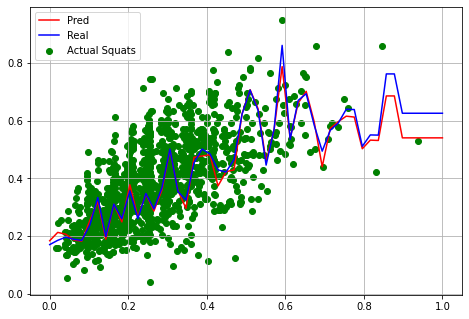

In [331]:
xfit = np.linspace(0, 1)
yfit = RandomForestRegressor().fit(S_bw, s_pred).predict(xfit[:, None])
zfit = RandomForestRegressor().fit(S_bw, s_test).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_test, color = 'g', label='Actual Squats')
plt.plot(xfit, yfit, '-r', color='red', label='Pred')
plt.plot(xfit, zfit, '-r', color='blue', label='Real')
ax.legend()
ax.grid(True)
plt.show()